# Import Libraries

In [1]:
import warnings;
warnings.simplefilter('ignore')

In [207]:
import pandas as pd
import seaborn as sns
import numpy as np
from prophet import Prophet
from dateutil.parser import parse
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.serialize import model_to_json, model_from_json

# Import Dataset

Download the original dataset from Kaggle: ['Financial Product and Services Cutomers com'](https://www.kaggle.com/datasets/taeefnajib/bank-customer-complaints/data) and put it into this folder to continue with this step.

or

You can jump all the Import Dataset step down to the Save and Load Dataset to get the final preprocessed database, saved in this folder as "dataset.csv" and load it to continue with the training.

In [3]:
ds = pd.read_csv('customer_complaints.csv')

In [ ]:
ds.head()

,Complaint ID,Date received,Product,Sub-product,Issue,Sub-issue,Company public response,Company,State,ZIP code,Consumer consent provided?,Submitted via,Date sent to company,Timely response?,Consumer disputed?,Company response to consumer
0,2738619,2017-11-27,Mortgage,Conventional home mortgage,Trouble during payment process,NaN,No,NATIONSTAR MORTGAGE LLC,PA,189XX,Consent provided,Web,2017-11-27,Yes,Unknown,Closed with explanation
1,2933849,2018-06-12,Mortgage,Conventional home mortgage,Trouble during payment process,NaN,No,NATIONSTAR MORTGAGE LLC,CO,80132,Consent provided,Web,2018-06-12,Yes,Unknown,Closed with explanation
2,1165653,2014-12-21,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,No,NATIONSTAR MORTGAGE LLC,CA,91701,Unknown,Web,2014-12-21,Yes,No,Closed with explanation
3,3316943,2019-07-24,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,Yes,Experian Information Solutions Inc.,CA,90221,Consent not provided,Web,2019-07-24,Yes,Unknown,Closed with explanation
4,3157550,2019-02-20,"Payday loan, title loan, or personal loan",Installment loan,Struggling to pay your loan,NaN,No,Santander Consumer USA Holdings Inc.,NC,27410,Consent not provided,Web,2019-02-20,Yes,Unknown,Closed with explanation


In [4]:
n = ds['Date received'].value_counts().sum()
n

1473407

In [5]:
prod = pd.DataFrame(ds['Product'].value_counts()).reset_index()
prod


,Product,count
0,"Credit reporting, credit repair services, or o...",323549
1,Mortgage,293396
2,Debt collection,275759
3,Credit reporting,140429
4,Credit card,89190
5,Bank account or service,86205
6,Credit card or prepaid card,65472
7,Student loan,55854
8,Checking or savings account,55709
9,Consumer Loan,31575


In [6]:
ds = ds.replace({'Credit reporting': 'Credit reporting, credit repair services, or other personal consumer reports',
                 "Payday loan": 'Payday loan, title loan, or personal loan',
                 "Prepaid card": 'Credit card or prepaid card',
                 "Credit card":'Credit card or prepaid card',
                 "Virtual currency": "Money transfer, virtual currency, or money service"
                 })

In [9]:
prod = pd.DataFrame(ds['Product'].value_counts()).reset_index()
prod

,Product,count
0,"Credit reporting, credit repair services, or o...",463978
1,Mortgage,293396
2,Debt collection,275759
3,Credit card or prepaid card,158481
4,Bank account or service,86205
5,Student loan,55854
6,Checking or savings account,55709
7,Consumer Loan,31575
8,"Payday loan, title loan, or personal loan",17171
9,Vehicle loan or lease,15068


<function matplotlib.pyplot.show(close=None, block=None)>

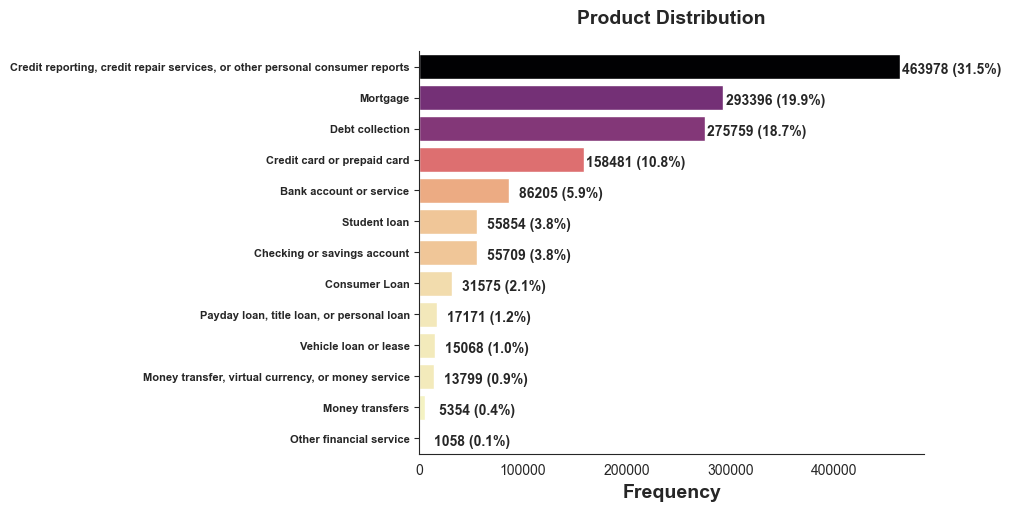

In [13]:
fig, ax = plt.subplots(layout='constrained', figsize=(10,5))
sns.set_style("ticks")

pal = sns.color_palette("magma_r", as_cmap=True)

sns.barplot(prod,
            y='Product',
            x='count',
            hue='count',
            palette=pal,
            legend=False
            )
sns.despine()
ax.set_xlabel("Frequency", fontsize=14, fontweight="bold")
ax.xaxis.set_ticks_position('none')
ax.set_yticklabels(prod.Product, fontsize=8, fontweight="bold")
ax.set_ylabel("")

# label each bar in histogram
for p in ax.patches:
 width = p.get_width()
 perc = width / n
 ax.text(y = p.get_y()+(p.get_height()/1.3),
         x = width+50000,
         s = '{:.0f} ({:.1%})'.format(width, perc),
         ha = "center",
         fontweight='bold')


plt.title("Product Distribution", fontsize=14, pad=20, fontweight='bold')

plt.show

In [14]:
dataset = ds[ds['Product'] == 'Credit reporting, credit repair services, or other personal consumer reports']
dataset.head()

,Complaint ID,Date received,Product,Sub-product,Issue,Sub-issue,Company public response,Company,State,ZIP code,Consumer consent provided?,Submitted via,Date sent to company,Timely response?,Consumer disputed?,Company response to consumer
3,3316943,2019-07-24,"Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o...",Incorrect information on your report,Information belongs to someone else,Yes,Experian Information Solutions Inc.,CA,90221,Consent not provided,Web,2019-07-24,Yes,Unknown,Closed with explanation
24,2982087,2018-08-06,"Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o...",Credit monitoring or identity theft protection...,Billing dispute for services,No,"SANTANDER HOLDINGS USA, INC.",CA,91945,Unknown,Web,2023-07-13,Yes,Unknown,Closed with explanation
28,3139549,2019-02-01,"Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o...",Incorrect information on your report,Information belongs to someone else,Yes,Experian Information Solutions Inc.,CA,90047,Other,Web,2019-02-01,Yes,Unknown,Closed with non-monetary relief
137,3424780,2019-11-01,"Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o...",Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,Yes,Experian Information Solutions Inc.,NJ,07081,Consent not provided,Web,2019-11-01,Yes,Unknown,Closed with explanation
144,3424075,2019-10-31,"Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o...",Incorrect information on your report,Information belongs to someone else,Yes,Experian Information Solutions Inc.,IN,47172,Consent not provided,Web,2019-10-31,Yes,Unknown,Closed with explanation


In [15]:
companies = pd.DataFrame(dataset['Company'].value_counts()).reset_index()[:10]
companies

,Company,count
0,"EQUIFAX, INC.",142227
1,Experian Information Solutions Inc.,126924
2,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",121722
3,CAPITAL ONE FINANCIAL CORPORATION,5288
4,SYNCHRONY FINANCIAL,3235
5,"CITIBANK, N.A.",3121
6,JPMORGAN CHASE & CO.,2785
7,WELLS FARGO & COMPANY,2353
8,LEXISNEXIS,2118
9,"BANK OF AMERICA, NATIONAL ASSOCIATION",2039


In [16]:
n2 = dataset['Company'].value_counts().sum()
n2

463978

<function matplotlib.pyplot.show(close=None, block=None)>

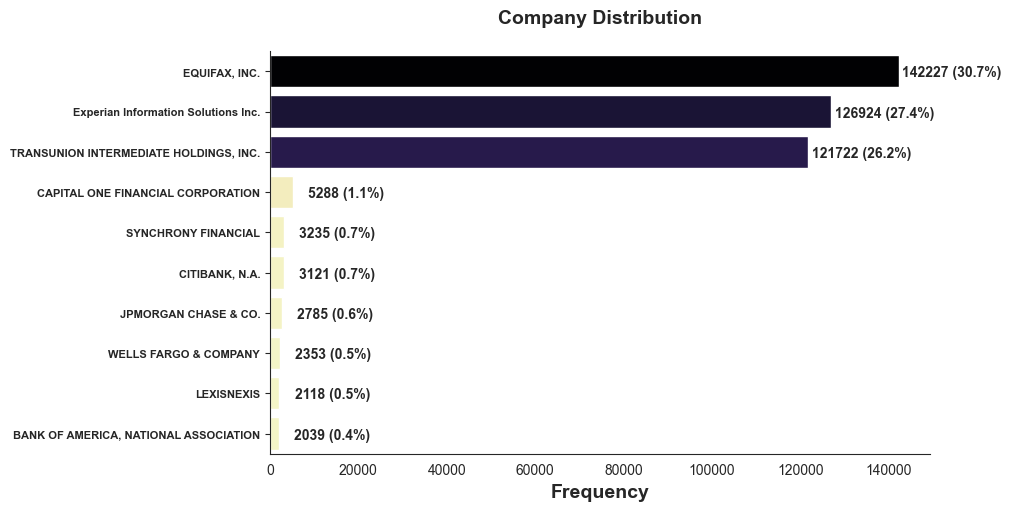

In [17]:
fig, ax = plt.subplots(layout='constrained', figsize=(10,5))
sns.set_style("ticks")

pal = sns.color_palette("magma_r", as_cmap=True)

sns.barplot(companies,
            y='Company',
            x='count',
            hue='count',
            palette=pal,
            legend=False
            )
sns.despine()
ax.set_xlabel("Frequency", fontsize=14, fontweight="bold")
ax.xaxis.set_ticks_position('none')
ax.set_yticklabels(companies.Company, fontsize=8, fontweight="bold")
ax.set_ylabel("")

# label each bar in histogram
for p in ax.patches:
 width = p.get_width()
 perc = width / n2
 ax.text(y = p.get_y()+(p.get_height()/1.5),
         x = width+12000,
         s = '{:.0f} ({:.1%})'.format(width, perc),
         ha = "center",
         fontweight='bold')

plt.title("Company Distribution", fontsize=14, pad=20, fontweight='bold')

plt.show

In [18]:
dataset['n'] = 1
dataset = dataset[dataset['Company'] == "EQUIFAX, INC."]
dataset.Company.unique()

array(['EQUIFAX, INC.'], dtype=object)

In [19]:
dataset = dataset[['Date received', 'n']]
dataset

,Date received,n
160,2019-10-30,1
213,2019-10-30,1
237,2019-10-29,1
241,2019-10-29,1
418,2019-11-27,1
...,...,...
1473299,2017-09-22,1
1473319,2016-05-12,1
1473322,2014-03-16,1
1473332,2016-10-14,1


In [20]:
# Converting the data into a datetime format
dataset['Date received'] = dataset['Date received'].apply(lambda x: parse(x))
dataset

,Date received,n
160,2019-10-30,1
213,2019-10-30,1
237,2019-10-29,1
241,2019-10-29,1
418,2019-11-27,1
...,...,...
1473299,2017-09-22,1
1473319,2016-05-12,1
1473322,2014-03-16,1
1473332,2016-10-14,1


In [21]:
dataset = dataset.groupby('Date received', as_index=False).count()
dataset

,Date received,n
0,2012-10-22,7
1,2012-10-23,23
2,2012-10-24,20
3,2012-10-25,15
4,2012-10-26,16
...,...,...
2615,2019-12-27,136
2616,2019-12-28,63
2617,2019-12-29,86
2618,2019-12-30,131


In [22]:
dataset.columns = ['ds', 'y']
dataset

,ds,y
0,2012-10-22,7
1,2012-10-23,23
2,2012-10-24,20
3,2012-10-25,15
4,2012-10-26,16
...,...,...
2615,2019-12-27,136
2616,2019-12-28,63
2617,2019-12-29,86
2618,2019-12-30,131


<function matplotlib.pyplot.show(close=None, block=None)>

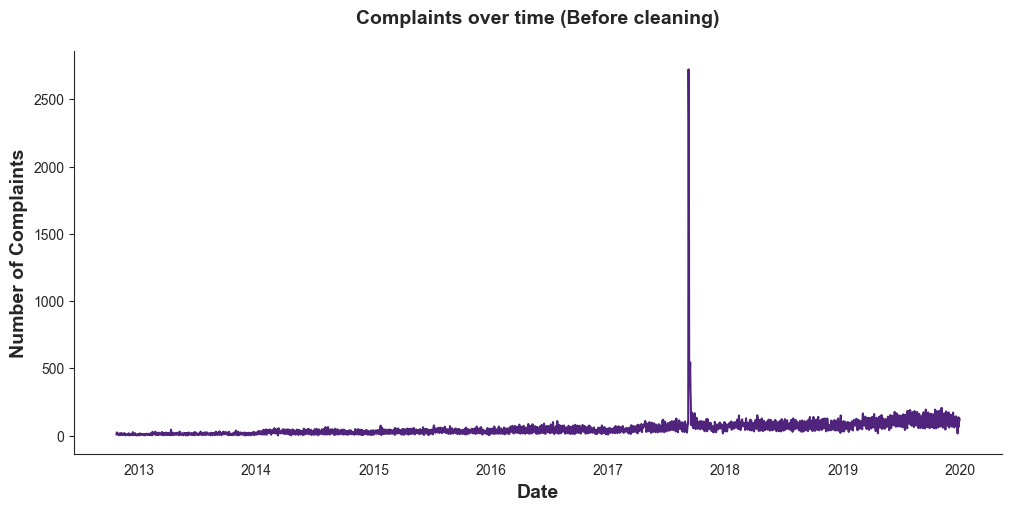

In [28]:
fig, ax = plt.subplots(layout='constrained', figsize=(10,5))
sns.set_style("ticks")

sns.lineplot(
    data=dataset, x="ds", y="y",
    color="#50237C"
)
sns.despine()
ax.set_xlabel("Date", fontsize=14, fontweight="bold")
ax.xaxis.set_ticks_position('none')
ax.set_ylabel("Number of Complaints", fontsize=14, fontweight="bold")

plt.title("Complaints over time (Before cleaning)", fontsize=14, pad=20, fontweight='bold')

plt.show

In [30]:
dataset[dataset['y'] > 250]

,ds,y
1775,2017-09-08,2722
1776,2017-09-09,2316
1777,2017-09-10,367
1778,2017-09-11,525
1779,2017-09-12,456
1780,2017-09-13,544
1781,2017-09-14,334


In [31]:
dataset = dataset[dataset['y'] < 200]

<function matplotlib.pyplot.show(close=None, block=None)>

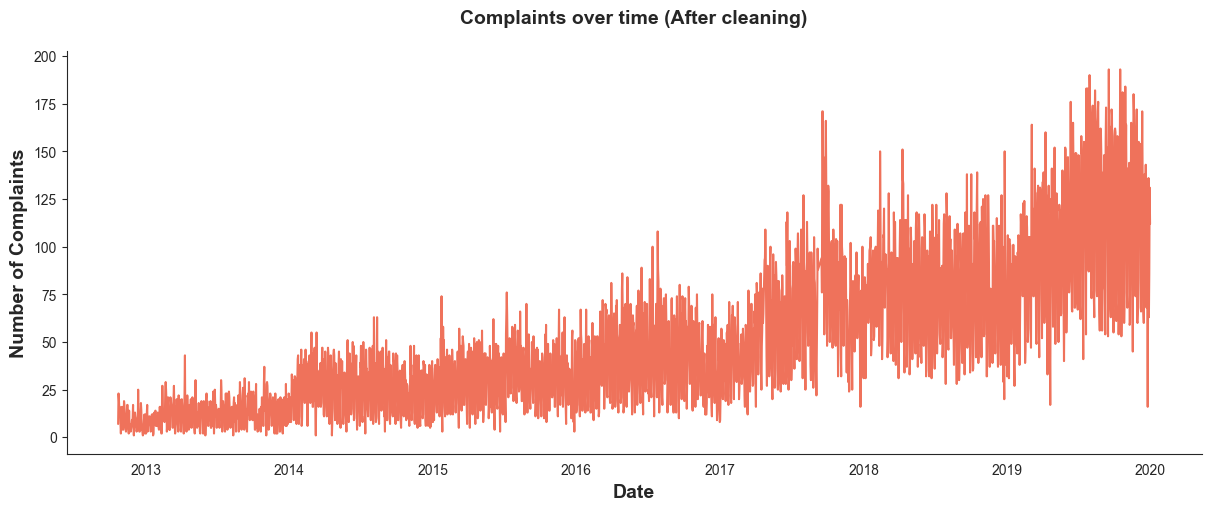

In [32]:
fig, ax = plt.subplots(layout='constrained', figsize=(12,5))
sns.set_style("ticks")

sns.lineplot(
    data=dataset, x="ds", y="y",
    color="#EF725B"
)
sns.despine()
ax.set_xlabel("Date", fontsize=14, fontweight="bold")
ax.xaxis.set_ticks_position('none')
ax.set_ylabel("Number of Complaints", fontsize=14, fontweight="bold")

plt.title("Complaints over time (After cleaning)", fontsize=14, pad=20, fontweight='bold')

plt.show

In [ ]:
# Standarize the dataset NOT USED
# def standarize(df):
#   scal = StandardScaler()
#   scal = scal.fit(df)
#   return scal.transform(df)

In [ ]:
# y = dataset['y']
# data = dataset.copy()
# data['y'] = pd.DataFrame(standarize(np.reshape(y, (-1,1))))
# data.head()

In [ ]:
dataset.shape

(2611, 2)

In [78]:
# Separate the Train and testing dataset
tr_size = int(len(dataset)* .95)
tr_size, len(dataset) - tr_size, len(dataset)

(2480, 131, 2611)

In [79]:
ds_train = dataset[:tr_size]
ds_test = dataset[tr_size:]

ds_train.shape, ds_test.shape

((2480, 2), (131, 2))

# Save and Load Dataset

In [46]:
# Save the data Preprocessed
#dataset.to_csv("dataset.csv", index=False)
#ds_train.to_csv("train.csv", index=False)
#ds_test.to_csv("test.csv", index=False)

In [201]:
# Load the data
dataset = pd.read_csv('dataset.csv')
ds_train = pd.read_csv("train.csv")
ds_test = pd.read_csv("test.csv")

# Train Model

For more information about Prophet library go to ['Prophet'](https://facebook.github.io/prophet/docs/quick_start.html)

In [44]:
# Fitting with a Additive Model
m = Prophet(interval_width=0.95, daily_seasonality=True)
model = m.fit(ds_train)

17:42:26 - cmdstanpy - INFO - Chain [1] start processing
17:42:27 - cmdstanpy - INFO - Chain [1] done processing


# Cross Validation

In [45]:
# Cross-Validation with Additive model
dataset_cv = cross_validation(m, initial='800 days', period='80 days', horizon = '100 days')
dataset_cv.head()

  0%|          | 0/20 [00:00<?, ?it/s]

17:42:30 - cmdstanpy - INFO - Chain [1] start processing
17:42:30 - cmdstanpy - INFO - Chain [1] done processing
17:42:31 - cmdstanpy - INFO - Chain [1] start processing
17:42:31 - cmdstanpy - INFO - Chain [1] done processing
17:42:32 - cmdstanpy - INFO - Chain [1] start processing
17:42:32 - cmdstanpy - INFO - Chain [1] done processing
17:42:32 - cmdstanpy - INFO - Chain [1] start processing
17:42:32 - cmdstanpy - INFO - Chain [1] done processing
17:42:33 - cmdstanpy - INFO - Chain [1] start processing
17:42:33 - cmdstanpy - INFO - Chain [1] done processing
17:42:34 - cmdstanpy - INFO - Chain [1] start processing
17:42:34 - cmdstanpy - INFO - Chain [1] done processing
17:42:36 - cmdstanpy - INFO - Chain [1] start processing
17:42:36 - cmdstanpy - INFO - Chain [1] done processing
17:42:37 - cmdstanpy - INFO - Chain [1] start processing
17:42:38 - cmdstanpy - INFO - Chain [1] done processing
17:42:38 - cmdstanpy - INFO - Chain [1] start processing
17:42:39 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-03-16,34.288411,20.213327,48.062218,41,2015-03-15
1,2015-03-17,38.530677,24.736923,52.052450,46,2015-03-15
2,2015-03-18,39.067670,25.883302,53.376366,53,2015-03-15
3,2015-03-19,37.196080,22.747770,50.929522,50,2015-03-15
4,2015-03-20,35.554992,20.956801,50.838293,48,2015-03-15


In [47]:
# Metrics for the horizon of the prediction
dataset_p = performance_metrics(dataset_cv)
dataset_p.head(10)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,10 days,285.489823,16.896444,13.400725,0.299700,0.202396,0.252167,0.794724
1,11 days,298.085463,17.265152,13.468725,0.296963,0.202028,0.250162,0.805276
2,12 days,270.800207,16.456008,12.722276,0.299715,0.194836,0.247543,0.824874
3,13 days,270.857266,16.457742,12.603547,0.304805,0.199195,0.249026,0.824874
4,14 days,280.644156,16.752437,12.952427,0.305755,0.202396,0.253668,0.814824
5,15 days,274.364416,16.563949,12.781419,0.305631,0.201744,0.251308,0.815578
6,16 days,263.740379,16.240086,12.596107,0.304230,0.198880,0.248200,0.830402
7,17 days,279.873494,16.729420,12.986932,0.304699,0.199577,0.249987,0.819849
8,18 days,284.357249,16.862896,12.869307,0.319532,0.188795,0.249516,0.815327
9,19 days,291.282118,17.066989,12.825006,0.318097,0.188795,0.249009,0.820352


In [48]:
# get the day with the best performance of prediction
dataset_p.iloc[np.argmin(dataset_p['mape'])]

horizon     45 days 00:00:00
mse               439.216239
rmse               20.957486
mae                14.172503
mape                0.254754
mdape                0.16573
smape               0.234983
coverage            0.785176
Name: 35, dtype: object

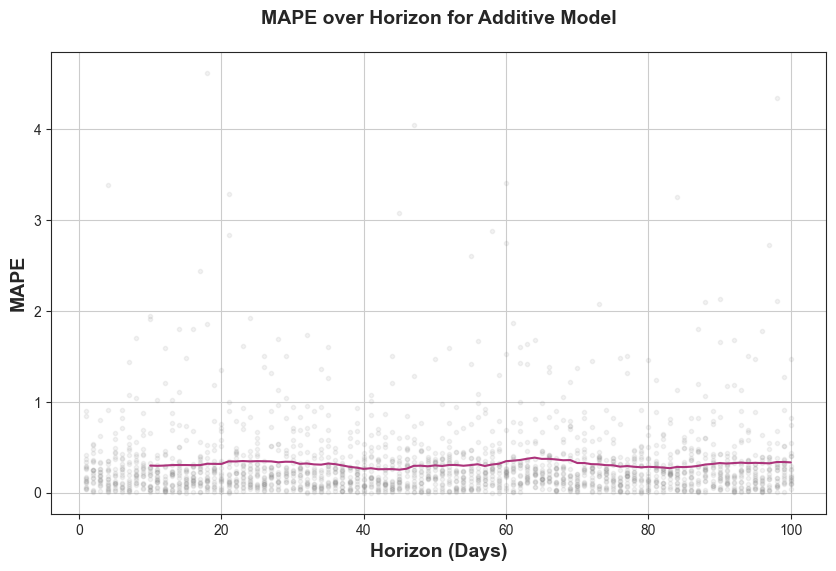

In [59]:
a = plot_cross_validation_metric(dataset_cv, metric='mape', color='#AC337B')

plt.ylabel("MAPE", fontsize=14, fontweight="bold")
plt.xlabel("Horizon (Days)", fontsize=14, fontweight="bold")
plt.title("MAPE over Horizon for Additive Model", fontsize=14, pad=20, fontweight='bold')

plt.show()

In [50]:
# Fitting and -Cross-validation with a Multiplicative model
m2 = Prophet(interval_width=0.95, changepoint_prior_scale=0.05, seasonality_mode='multiplicative')
model2 = m2.fit(ds_train)
dataset_cv2 = cross_validation(m2, initial='800 days', period='80 days', horizon = '100 days')
dataset_p2 = performance_metrics(dataset_cv2)
dataset_p2.head(10)

17:43:48 - cmdstanpy - INFO - Chain [1] start processing
17:43:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/20 [00:00<?, ?it/s]

17:43:49 - cmdstanpy - INFO - Chain [1] start processing
17:43:50 - cmdstanpy - INFO - Chain [1] done processing
17:43:50 - cmdstanpy - INFO - Chain [1] start processing
17:43:50 - cmdstanpy - INFO - Chain [1] done processing
17:43:51 - cmdstanpy - INFO - Chain [1] start processing
17:43:51 - cmdstanpy - INFO - Chain [1] done processing
17:43:51 - cmdstanpy - INFO - Chain [1] start processing
17:43:52 - cmdstanpy - INFO - Chain [1] done processing
17:43:52 - cmdstanpy - INFO - Chain [1] start processing
17:43:52 - cmdstanpy - INFO - Chain [1] done processing
17:43:52 - cmdstanpy - INFO - Chain [1] start processing
17:43:53 - cmdstanpy - INFO - Chain [1] done processing
17:43:53 - cmdstanpy - INFO - Chain [1] start processing
17:43:53 - cmdstanpy - INFO - Chain [1] done processing
17:43:54 - cmdstanpy - INFO - Chain [1] start processing
17:43:54 - cmdstanpy - INFO - Chain [1] done processing
17:43:54 - cmdstanpy - INFO - Chain [1] start processing
17:43:55 - cmdstanpy - INFO - Chain [1]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,10 days,249.117144,15.783445,11.870034,0.227560,0.167449,0.211999,0.780402
1,11 days,264.491474,16.263194,12.133034,0.230102,0.174731,0.216199,0.785427
2,12 days,254.720113,15.959953,12.065917,0.240401,0.177573,0.224648,0.789698
3,13 days,264.178912,16.253582,12.272507,0.245622,0.178560,0.227107,0.779648
4,14 days,282.892545,16.819410,12.721261,0.252890,0.190418,0.233338,0.754774
5,15 days,271.029458,16.462972,12.408206,0.252602,0.186920,0.232542,0.765075
6,16 days,276.992364,16.643088,12.481046,0.257278,0.190418,0.236555,0.754523
7,17 days,295.412253,17.187561,12.900382,0.253967,0.193558,0.238191,0.729648
8,18 days,308.261287,17.557371,13.046038,0.259385,0.193127,0.239397,0.725126
9,19 days,323.193039,17.977570,13.423062,0.265574,0.199410,0.249319,0.704523


In [51]:
# get the day with the best performance of prediction
dataset_p2.iloc[np.argmin(dataset_p2['mape'])]

horizon     10 days 00:00:00
mse               249.117144
rmse               15.783445
mae                11.870034
mape                 0.22756
mdape               0.167449
smape               0.211999
coverage            0.780402
Name: 0, dtype: object

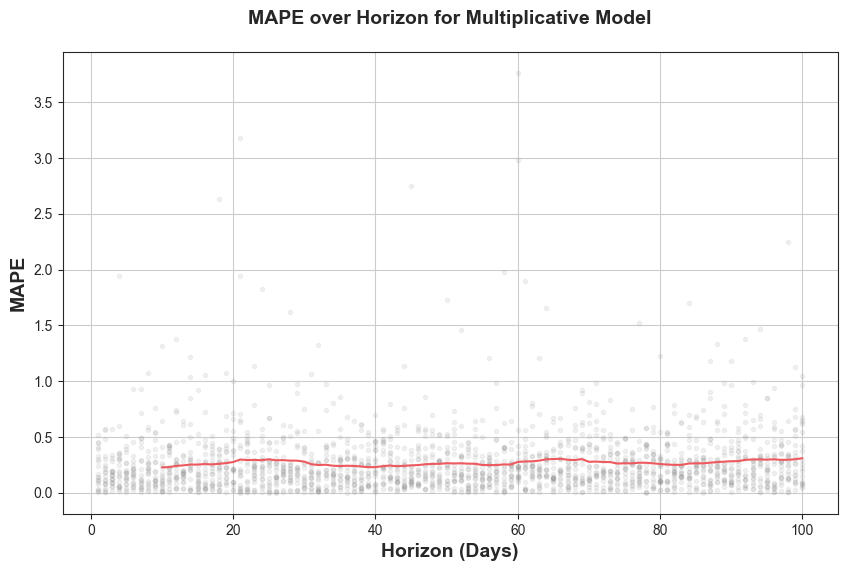

In [61]:
fig2 = plot_cross_validation_metric(dataset_cv2, metric='mape', color='#ED595F')

plt.ylabel("MAPE", fontsize=14, fontweight="bold")
plt.xlabel("Horizon (Days)", fontsize=14, fontweight="bold")
plt.title("MAPE over Horizon for Multiplicative Model", fontsize=14, pad=20, fontweight='bold')

plt.show()

In [62]:
mape_res = pd.DataFrame({'Additive Model':dataset_p['mape'], 'Multiplicative Model': dataset_p2['mape']})

mape_res = mape_res.melt(var_name="model", value_name="mape")
mape_res

,model,mape
0,Additive Model,0.299700
1,Additive Model,0.296963
2,Additive Model,0.299715
3,Additive Model,0.304805
4,Additive Model,0.305755
...,...,...
177,Multiplicative Model,0.299897
178,Multiplicative Model,0.294964
179,Multiplicative Model,0.295857
180,Multiplicative Model,0.300159


<function matplotlib.pyplot.show(close=None, block=None)>

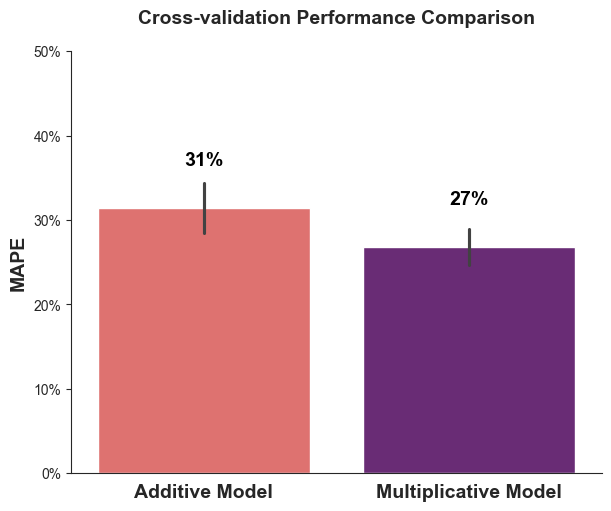

In [243]:
# Plot the MAPE for each cross-validation
fig, ax = plt.subplots(layout='constrained', figsize=(6,5))
sns.set_style("ticks")


sns.barplot(
    data=mape_res, x="model", y="mape",
    palette='magma_r', errorbar="sd"
)
sns.despine()
ax.set_xlabel("")
ax.set_ylim([0, 0.5])
ax.xaxis.set_ticks_position('none')
ax.set_ylabel("MAPE", fontsize=14, fontweight="bold")
ax.set_xticklabels(['Additive Model', 'Multiplicative Model'], fontsize=14, fontweight="bold")
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

# label each bar in histogram
for p in ax.patches:
 height = p.get_height()
 ax.text(x = p.get_x()+(p.get_width()/2),
         y = height+.05,
         s = '{:.0%}'.format(height),
         ha = "center",
         fontweight='bold',
         size=14,
         color="black")


plt.title("Cross-validation Performance Comparison", fontsize=14, pad=20, fontweight='bold')

plt.show


# Forecast and Test the model

In [162]:
# Forecasting with the Additive model
future = m.make_future_dataframe(periods=131, freq='D')
forecast = m.predict(future)

In [163]:
yhat_model1 = forecast[['ds', 'yhat_lower', 'yhat_upper', 'yhat']][-131:]
yhat_model1.head()

,ds,yhat_lower,yhat_upper,yhat
2480,2019-08-22,88.465898,148.298660,117.170318
2481,2019-08-23,79.450076,140.322277,109.415207
2482,2019-08-24,55.054695,115.664768,83.782722
2483,2019-08-25,53.765540,110.453253,80.938264
2484,2019-08-26,78.713833,140.407556,109.248965


In [164]:
# Forecasting with the Multiplicative model
future2 = m2.make_future_dataframe(periods=131, freq='D')
forecast2 = m2.predict(future2)

In [165]:
yhat_model2 = forecast2[['ds', 'yhat_lower', 'yhat_upper', 'yhat']][-131:]
yhat_model2.head()

,ds,yhat_lower,yhat_upper,yhat
2480,2019-08-22,102.115910,152.544575,126.634761
2481,2019-08-23,84.607967,134.418955,108.579318
2482,2019-08-24,29.937650,79.057889,54.665794
2483,2019-08-25,23.398579,75.432441,48.883453
2484,2019-08-26,85.193291,135.004042,109.028743


In [166]:
yhat_model1.ds = yhat_model1.ds.dt.strftime('%Y-%m-%d')
yhat_model1.ds = yhat_model1.ds.astype('str')
yhat_model2.ds = yhat_model2.ds.dt.strftime('%Y-%m-%d')
yhat_model2.ds = yhat_model2.ds.astype('str')

yhat_model1.dtypes

ds             object
yhat_lower    float64
yhat_upper    float64
yhat          float64
dtype: object

In [167]:
yhat_model1

,ds,yhat_lower,yhat_upper,yhat
2480,2019-08-22,88.465898,148.298660,117.170318
2481,2019-08-23,79.450076,140.322277,109.415207
2482,2019-08-24,55.054695,115.664768,83.782722
2483,2019-08-25,53.765540,110.453253,80.938264
2484,2019-08-26,78.713833,140.407556,109.248965
...,...,...,...,...
2606,2019-12-26,81.931256,143.493925,113.286384
2607,2019-12-27,79.153242,136.463836,106.061467
2608,2019-12-28,51.252751,112.525880,80.989573
2609,2019-12-29,47.930380,108.096068,78.729227


In [168]:
# Merging the results
all_fc = ds_test.merge(yhat_model1, how="inner", on="ds")
all_fc = all_fc.merge(yhat_model2, how="inner", on="ds")
all_fc.columns = ['ds', 'True', 'yhat_L_mod1', 'yhat_U_mo1', 'Additive', 'yhat_L_mod2', 'yhat_U_mo2', 'Multiplicative']

In [169]:
all_fc

,ds,True,yhat_L_mod1,yhat_U_mo1,Additive,yhat_L_mod2,yhat_U_mo2,Multiplicative
0,2019-08-22,131,88.465898,148.298660,117.170318,102.115910,152.544575,126.634761
1,2019-08-23,113,79.450076,140.322277,109.415207,84.607967,134.418955,108.579318
2,2019-08-24,66,55.054695,115.664768,83.782722,29.937650,79.057889,54.665794
3,2019-08-25,56,53.765540,110.453253,80.938264,23.398579,75.432441,48.883453
4,2019-08-26,156,78.713833,140.407556,109.248965,85.193291,135.004042,109.028743
...,...,...,...,...,...,...,...,...
125,2019-12-26,78,81.931256,143.493925,113.286384,85.418734,136.798379,110.693373
126,2019-12-27,136,79.153242,136.463836,106.061467,67.758165,116.759120,92.549190
127,2019-12-28,63,51.252751,112.525880,80.989573,10.823100,61.772074,35.868298
128,2019-12-29,86,47.930380,108.096068,78.729227,6.251667,56.967469,31.028632


In [171]:
# Getting only the real and estimated y
all_fc_y = all_fc[['ds', 'True', 'Additive', 'Multiplicative']]
all_fc_m = all_fc_y.melt('ds', var_name="Results", value_name="ys")
all_fc_m.head()

,ds,Results,ys
0,2019-08-22,True,131.0
1,2019-08-23,True,113.0
2,2019-08-24,True,66.0
3,2019-08-25,True,56.0
4,2019-08-26,True,156.0


In [172]:
all_fc_m.ds = pd.to_datetime(all_fc_m.ds)

In [173]:
all_fc_m

,ds,Results,ys
0,2019-08-22,True,131.000000
1,2019-08-23,True,113.000000
2,2019-08-24,True,66.000000
3,2019-08-25,True,56.000000
4,2019-08-26,True,156.000000
...,...,...,...
385,2019-12-26,Multiplicative,110.693373
386,2019-12-27,Multiplicative,92.549190
387,2019-12-28,Multiplicative,35.868298
388,2019-12-29,Multiplicative,31.028632


<function matplotlib.pyplot.show(close=None, block=None)>

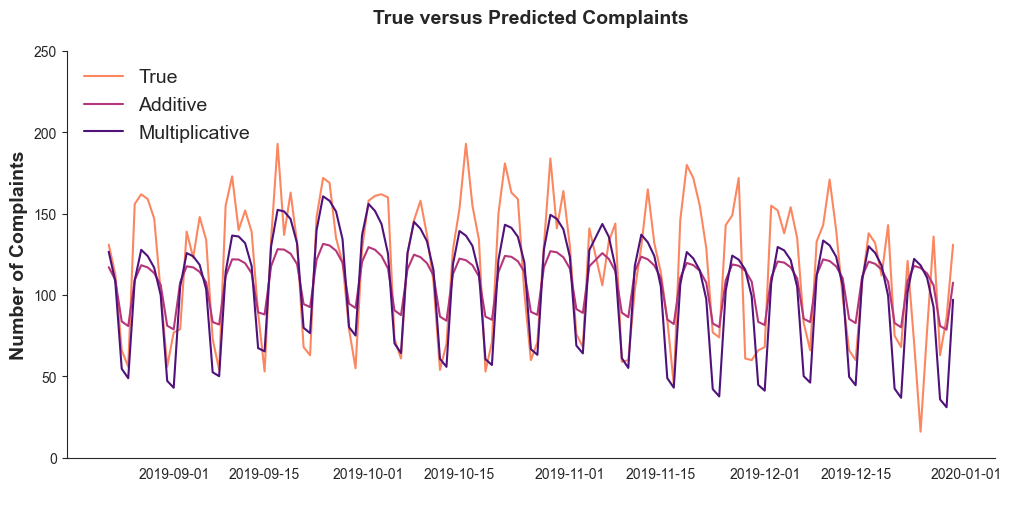

In [174]:
# Plotting the forecast of both models for the testing data
fig, ax = plt.subplots(layout='constrained', figsize=(10,5))
sns.set_style("ticks")

sns.lineplot(
    data=all_fc_m,
    x="ds", y="ys", hue="Results",
    palette="magma_r",
)
sns.despine()
ax.set_xlabel(" ")
ax.xaxis.set_ticks_position('none')
ax.set_ylabel("Number of Complaints", fontsize=14, fontweight="bold")
ax.legend(fontsize=14, loc='upper left', edgecolor='white')
ax.set_ylim([0, 250])
#ax.set_xlim([pd.to_datetime('2019-08-15'), pd.to_datetime('2020-01-01') ])

plt.title("True versus Predicted Complaints", fontsize=14, pad=20, fontweight='bold')

plt.show

In [176]:
# Calculating MSE and RMSE to compare the performance of both models
mod1_se = np.square(all_fc['Additive'] - all_fc['True'])
mod1_mse = np.mean(mod1_se).round(1)
mod1_rmse = np.sqrt(mod1_mse).round(1)
mod1_mape = np.mean(np.abs(all_fc['True'] - all_fc['Additive'])/np.abs(all_fc['True'])).round(2)

mod2_se = np.square(all_fc['Multiplicative'] - all_fc['True'])
mod2_mse = np.mean(mod2_se).round(1)
mod2_rmse = np.sqrt(mod2_mse).round(1)
mod2_mape = np.mean(np.abs(all_fc['True'] - all_fc['Multiplicative'])/np.abs(all_fc['True'])).round(2)

perf_models = pd.DataFrame({
    'Additive Model':{
        'MSE':mod1_mse,
        'RMSE':mod1_rmse,
        'MAPE':'{:.0%}'.format(mod1_mape)
    },
    'Multiplicative Model':{
        'MSE':mod2_mse,
        'RMSE':mod2_rmse,
        'MAPE':'{:.0%}'.format(mod2_mape)
    }
})

perf_models

,Additive Model,Multiplicative Model
MSE,950.6,715.8
RMSE,30.8,26.8
MAPE,28%,23%


In [177]:
ds_test

,ds,y
2480,2019-08-22,131
2481,2019-08-23,113
2482,2019-08-24,66
2483,2019-08-25,56
2484,2019-08-26,156
...,...,...
2606,2019-12-27,136
2607,2019-12-28,63
2608,2019-12-29,86
2609,2019-12-30,131


In [212]:
ds_test_2 = ds_test.copy()
ds_test_2.ds = ds_test_2.ds.astype('datetime64[ns]')

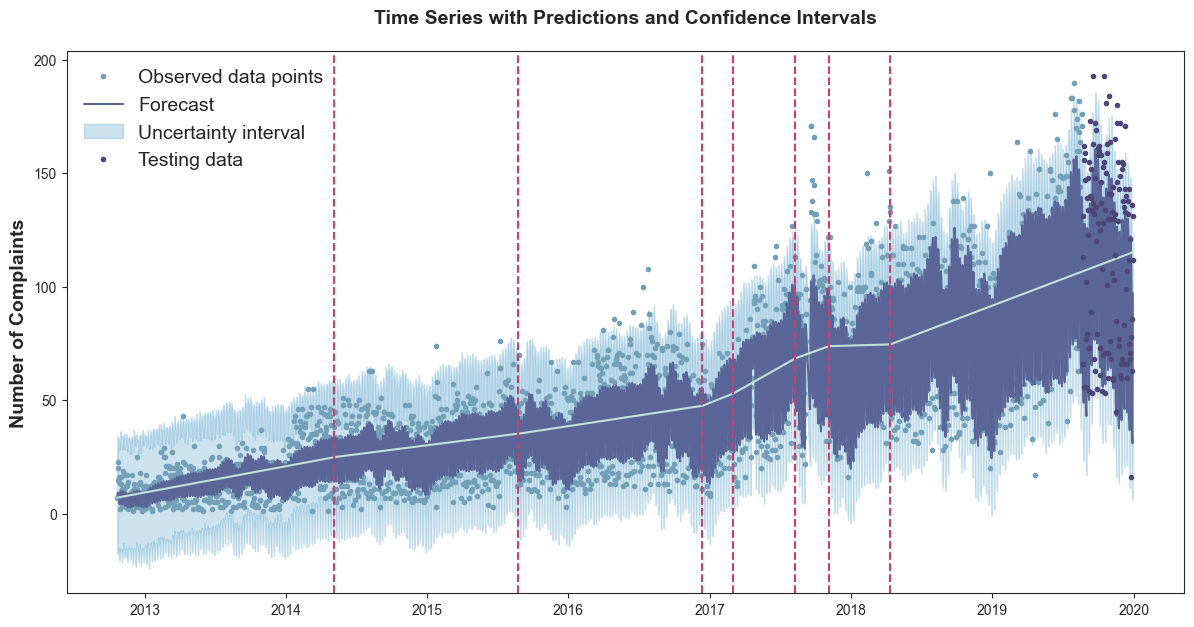

In [365]:
# Plot the time series with predictions made by the Multiplicative Model

plot2 = m2.plot(forecast2, xlabel="", ylabel="Complaints", figsize=(12,6), include_legend=True)
a = add_changepoints_to_plot(plot2.gca(), m2, forecast2)
b = plt.plot(ds_test_2['ds'], ds_test_2['y'], 'o', color='#4E4678', markersize=3, label="Testing data")

plt.ylabel("Number of Complaints", fontsize=14, fontweight="bold")
plt.grid(False)
plt.gca().get_lines()[0].set_color("#739FB7")
plt.gca().get_lines()[1].set_color("#5A6697")
plt.gca().get_lines()[2].set_color("#BFE3D6")
for i in [3,4,5,6,7,8,9]:
    plt.gca().get_lines()[i].set_color("#C83D72")
plt.title("Time Series with Predictions and Confidence Intervals", fontsize=14, pad=20, fontweight='bold')
plt.legend(fontsize=14, loc='upper left', edgecolor='white')



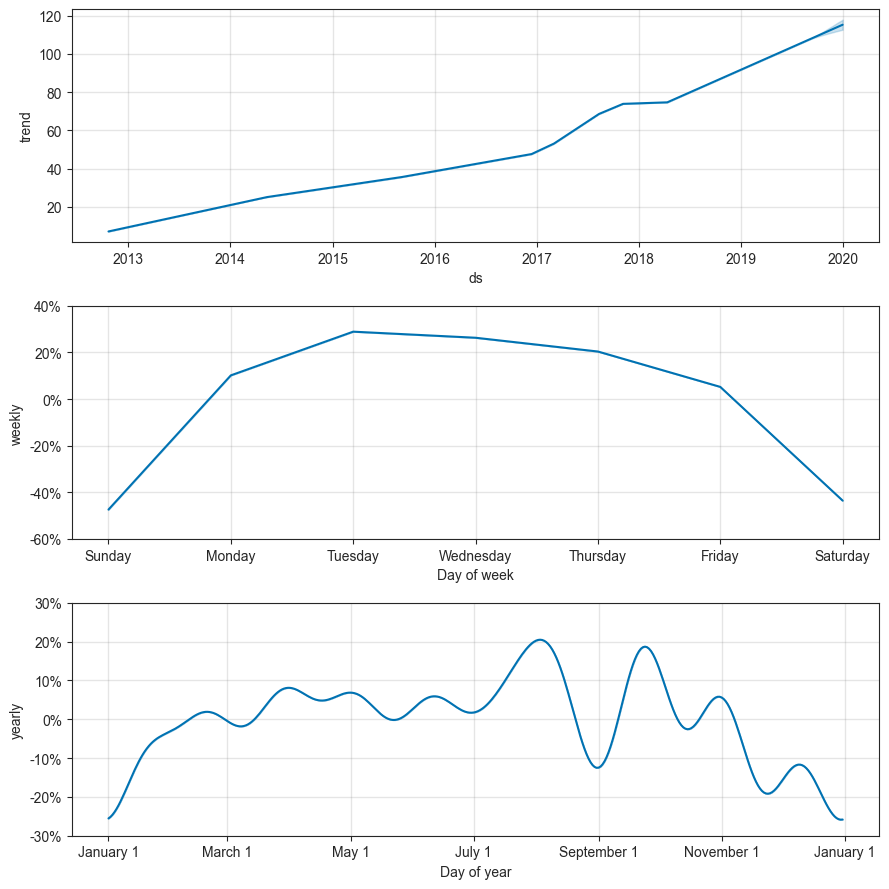

In [241]:
a = m2.plot_components(forecast2)

plt.show()

In [ ]:
# Plot the time series with predictions made by the Additive Model
plot1 = m.plot(forecast, xlabel="", ylabel="Complaints", figsize=(12,6), include_legend=True)
a = add_changepoints_to_plot(plot1.gca(), m, forecast)
b = plt.plot(ds_test['ds'], ds_test['y'], 'o', color='b', markersize=3, label="Testing data")
plt.legend()


# Save and load the model

In [ ]:
# Save the model
with open('serialized_model.json', 'w') as fout:
    fout.write(model_to_json(m))

In [37]:
# Load the model
with open('serialized_model.json', 'r') as fin:
    m = model_from_json(fin.read())